---
title: Full Design Pipeline
---



In [1]:
%matplotlib inline

In [2]:
import numpy
import shapely.geometry as sg

import foldable_robotics
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics.dxf 
import foldable_robotics.manufacturing
import foldable_robotics.parts.castellated_hinge1

import idealab_tools.plot_tris
from math import pi, sin,cos,tan
import idealab_tools.text_to_polygons

import os
import foldable_robotics.solidworks_support

In [3]:

foldable_robotics.display_height=200
foldable_robotics.line_width=.5


In [4]:
def get_bodies(filename, layername, num_layers):
    '''read all the lwpolylines from a particular layer name and create a laminate from them'''
    body = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)

    bodies = [Layer(sg.Polygon(item)) for item in body]
    body = bodies.pop(0)
    for item in bodies:
        body ^= item
    body = body.to_laminate(num_layers)
    return body

In [5]:
def get_hinge_lines(filename,layername):
    '''read all the lines and lwpolylines from a dxf and add to a list of two-point line segments'''
    hinge_lines1 = foldable_robotics.dxf.read_lines(filename,layer=layername)
    hinge_lines2 = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername)
    hinge_lines3 = []
    for points in hinge_lines2:
        hinge_lines3.append(points[:2])
    hinge_lines = hinge_lines1 +hinge_lines3
    return hinge_lines

In [6]:
def hinge_lines_to_hinges(hinge_lines,hinge):
    '''take a list of two-point line segments, along with a pre-defined hinge and stretch the hinge to match the line segments'''
    lam = Layer().to_laminate(len(hinge))
    all_hinges = []    
    for p3,p4 in hinge_lines:
        all_hinges.append(hinge.map_line_stretch((0,0),(1,0),p3,p4))
    all_hinges = lam.unary_union(*all_hinges)
    return all_hinges
        

In [7]:
def get_cuts(filename,layername,thickness,num_layers):
    '''read all the lines and lwpolylines from a specific layer of a dxf and add to a list of two-point line segments'''

    cut_lines = foldable_robotics.dxf.read_lines(filename,layer=layername)
    cut_lines += foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)
    
    cuts = []
    for item in cut_lines:
        cuts.append(Layer(sg.LineString(item)))
    cuts = Layer().unary_union(*cuts)
    cuts<<=thickness/2
    cuts = cuts.to_laminate(num_layers)
    return cuts    

In [8]:
def get_holes(filename, layername,num_layers):
    '''read all the circles from a dxf and add to a n-layer laminate'''
    
    holes = foldable_robotics.dxf.read_circles(filename,layer='holes')
    
    holes2 = []
    for center, radius in holes:
        holes2.append(sg.Point(*center).buffer(radius))
    holes_layer = Layer(*holes2)
    holes_lam = holes_layer.to_laminate(num_layers)  
    return holes_lam

In [9]:
def hinge_width_calculator(desired_degrees,thickness):
    '''from a given thickness and a desired angular rotation, calculate the gap between thick segments'''
    theta = (180-desired_degrees)*pi/180
    w=thickness/tan(theta)
    return w

In [10]:
def polys_to_layer(l1):
    '''Take lists of verties, convert to polygons, and then merge them all into a layer.'''
    
    l1 = [sg.Polygon(item) for item in l1]
    l11 = Layer(l1.pop(0))
    for item in l1:
        l11 ^= Layer(item)
    return l11
    

In [11]:
def output_pdf(filename,design2,x,y,layers_separate = True):
    design2 = design2.translate(x,y)
    design2=design2.scale(1/25.4,1/25.4)
    design2=design2.scale(foldable_robotics.pdf.ppi,foldable_robotics.pdf.ppi)
    if isinstance(design2,Laminate):
        if not layers_separate:
            p=foldable_robotics.pdf.Page(filename+'.pdf')
            for d in design2:
    #        d = design2[0]
                for item in d.exteriors()+d.interiors():
                    p.draw_poly(item)
            p.close()
        else:
            for ii,d in enumerate(design2):
                p=foldable_robotics.pdf.Page(filename+'{0:03f}.pdf'.format(ii))
                for item in d.exteriors()+d.interiors():
                    p.draw_poly(item)
                p.close()

    elif isinstance(design2,Layer):
        p=foldable_robotics.pdf.Page(filename+'.pdf')
        for item in design2.exteriors()+design2.interiors():
            p.draw_poly(item)
        p.close()
        

In [12]:
def build_layer_numbers(num_layers, text_size = None, prop=None):
    text_size = text_size or 1
    prop = prop or {'family':'Arial','size':text_size}
    layer_ids = []
    for ii in range(num_layers): 
    
        l = idealab_tools.text_to_polygons.text_to_polygons('Layer '+str(ii),prop=prop)
        layer_ids.append(l)
    
    layer_ids = [polys_to_layer(item) for item in layer_ids]
    layer_id = Laminate(*layer_ids)
    return layer_id

In [13]:
def build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive):
    num_layers = len(design2)

    layer_id = build_layer_numbers(num_layers,text_size=jig_diameter)

    design_outer = foldable_robotics.manufacturing.unary_union(design2)
    bb1= (design_outer<<jig_hole_spacing/2).bounding_box()
    (x1,y1),p2 = bb1.bounding_box_coords()
    w,h = bb1.get_dimensions()
    w2 = round(w/jig_hole_spacing)*jig_hole_spacing
    h2 = round(h/jig_hole_spacing)*jig_hole_spacing
    
    points = []
    points.append(sg.Point(x1,y1))
    points.append(sg.Point(x1+w2,y1))
    points.append(sg.Point(x1,y1+h2))
    points.append(sg.Point(x1+w2,y1+h2))
    
    layer_id = layer_id.translate(x1+jig_diameter,y1-jig_diameter/2)
    placement_holes2 = Layer(*points)
    placement_holes2<<=(jig_diameter/2)
    sheet = (placement_holes2<<10).bounding_box()
    placement_holes2=placement_holes2.to_laminate(num_layers)
    sheet=sheet.to_laminate(num_layers)
    
    removable_scrap = calculate_removable_scrap(design2,sheet,support_width,is_adhesive)
    
    web = (removable_scrap-placement_holes2)-layer_id
    return web,sheet

In [14]:
def calculate_removable_scrap(design,sheet,width,is_adhesive):
    '''this computes all removable scrap given a sheet, a design, and a clearance width'''
    all_scrap = sheet-design

    ru = foldable_robotics.manufacturing.not_removable_up(design,is_adhesive)
    rd = foldable_robotics.manufacturing.not_removable_down(design,is_adhesive)
    
    removable_scrap_up = all_scrap-(ru<<width)
    removable_scrap_down = all_scrap-(rd<<width)

    removable_scrap = removable_scrap_up|removable_scrap_down
    return removable_scrap

In [15]:
folder = '../../../../ignore/_cad/spherical_example/'
input_filename = folder+'spherical - Sheet1_Drawing View2.yaml'
output_file_name = 'design.dxf'

In [16]:
#we're rounding to 1e-5
round_digits = 5
round_digits = 2

# how much we scale geometry in the yaml file before we import in python converting m to mm
prescale=1000

# helper variables to ensure faces are fully separated and that joints touch the faces.
body_prebuffer=-.01
joint_tolerance = 1e-5

# we'll talk about later
jig_diameter = 5
support_width = 1
kerf = .05
jig_hole_spacing=20
is_adhesive = [False,True,False,True,False]
arc_approx = 10

Using a predefined function in the foldable_robotics.solidworks_support module, process the yaml file generated from a solidworks-generated yaml file and convert it to a dxf.

(<foldable_robotics.layer.Layer at 0x7f52ab66d0a0>,
  <foldable_robotics.solidworks_support.Component at 0x7f52ab66d700>])

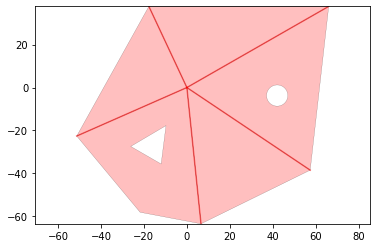

In [42]:
foldable_robotics.solidworks_support.process(input_filename,output_file_name,prescale,round_digits,body_prebuffer,joint_tolerance)

Prepare your hinge geometry

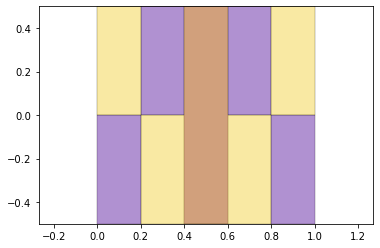

In [44]:
hinge = foldable_robotics.parts.castellated_hinge1.generate()
hinge.plot()

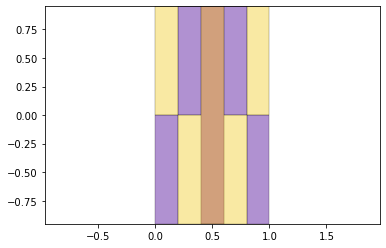

In [18]:
w=hinge_width_calculator(150,1.1)
hinge = hinge.scale(1,w)
hinge.plot()

In [19]:
NUMLAYERS = len(hinge)

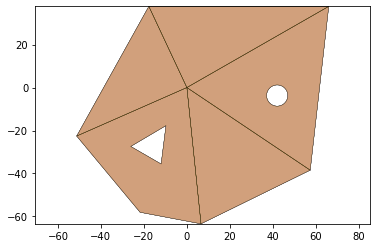

In [46]:
body = get_bodies(output_file_name,'body',NUMLAYERS)
body.plot()

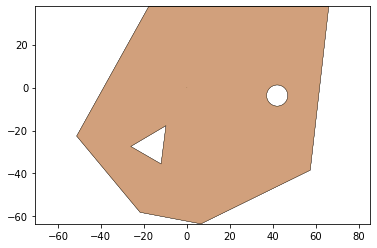

In [20]:
body = foldable_robotics.manufacturing.cleanup(body,.02)
body.plot()

In [47]:
joint_lines= get_hinge_lines(output_file_name,'joints')
joint_lines

[[[0.0, 1e-14], [66.0482534524777, 37.790495532087704]],
 [[-17.703655564581698, 37.790495532087704], [0.0, 1e-14]],
 [[57.4233956133225, -38.4714053614947], [0.0, 0.0]],
 [[-51.2952071486596, -22.5835093419984], [0.0, 0.0]],
 [[0.0, 0.0], [6.58212835093419, -63.438099106417496]]]

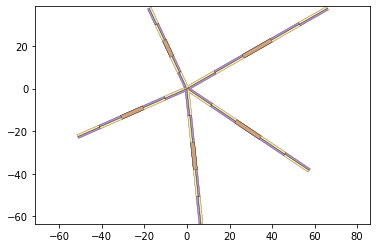

In [21]:
joints = hinge_lines_to_hinges(joint_lines,hinge)
joints = foldable_robotics.manufacturing.cleanup(joints,.02)
joints.plot()

In [48]:
cuts = get_cuts(output_file_name,'cuts',.02,NUMLAYERS)
cuts.plot()

('zero-size array to reduction operation minimum which has no identity',)


In [49]:
holes = get_holes(output_file_name,'holes',NUMLAYERS)
holes.plot()

('zero-size array to reduction operation minimum which has no identity',)


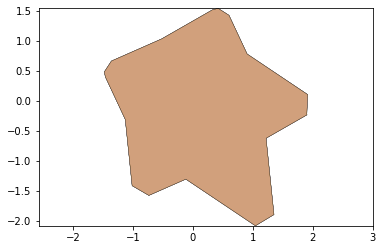

In [24]:
hole,dummy = foldable_robotics.manufacturing.calc_hole(joint_lines,w)
hole = hole.to_laminate(NUMLAYERS)
hole<<=.2
hole.plot()

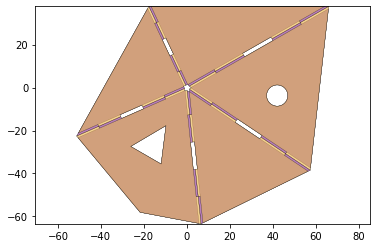

In [25]:
design2 = body- hole - joints - cuts - holes
design2.plot()

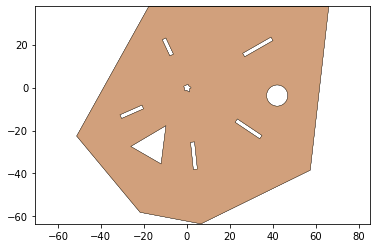

In [26]:
keepout =  foldable_robotics.manufacturing.keepout_laser(design2)
keepout.plot()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


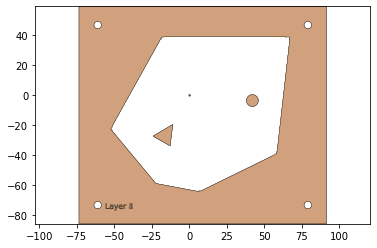

In [27]:
web,sheet=build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive)
web.plot()

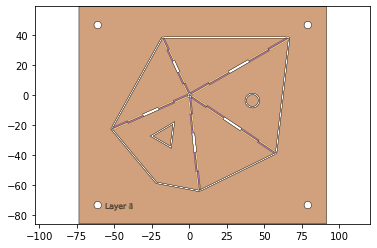

In [54]:
(web|design2).plot()

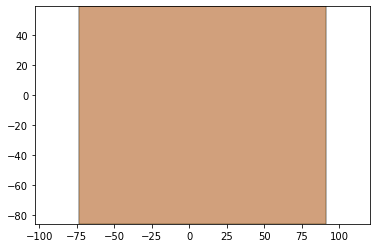

In [28]:
sheet.plot()

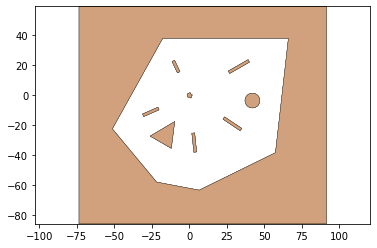

In [50]:
second_pass_scrap = sheet-keepout
second_pass_scrap.plot()

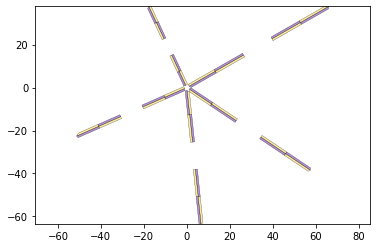

In [52]:
first_pass_scrap = sheet - design2-second_pass_scrap
first_pass_scrap = foldable_robotics.manufacturing.cleanup(first_pass_scrap,.00001)
first_pass_scrap.plot()

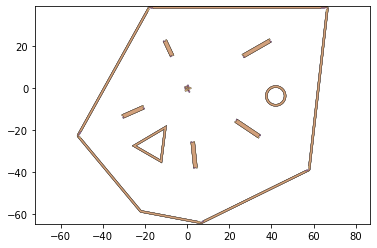

In [30]:
support = foldable_robotics.manufacturing.support(design2,foldable_robotics.manufacturing.keepout_laser,support_width,support_width/2)
support.plot()

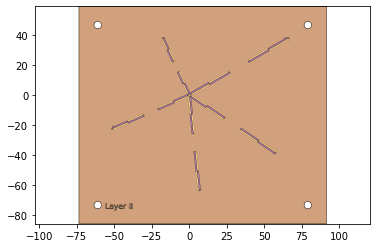

In [31]:
#Calculate the web by using only the material which can be cut, minus a gap determined by the support width.  Is that the only material you can use?
supported_design = web|design2|support
supported_design.plot()

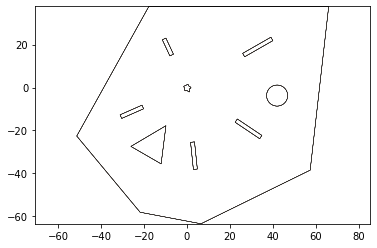

In [32]:
#cut_line = keepout<<kerf
cut_material = (keepout<<kerf)-keepout
cut_material.plot()

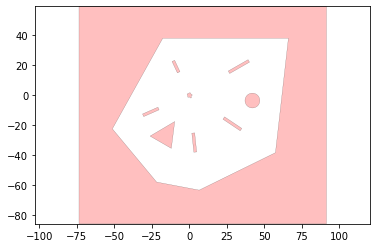

In [33]:
final_cut = sheet - keepout
final_cut = final_cut[0]
final_cut.plot()

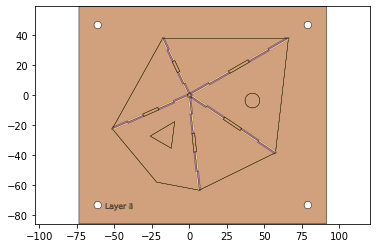

In [34]:
remaining_material = supported_design-cut_material
remaining_material.plot()

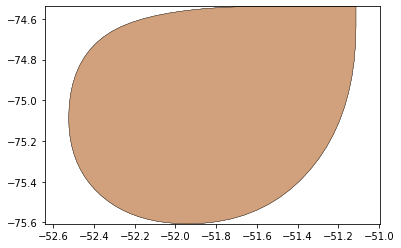

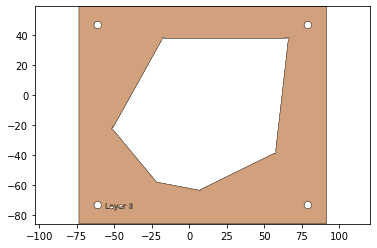

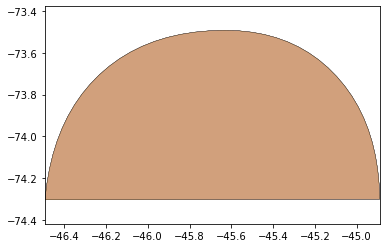

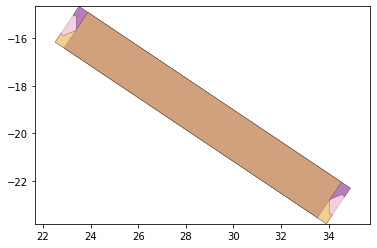

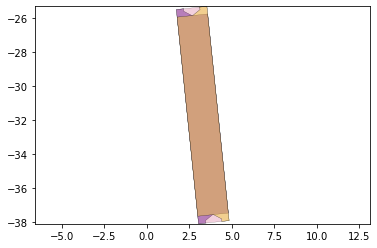

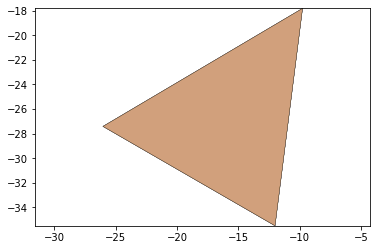

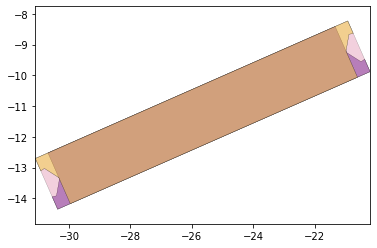

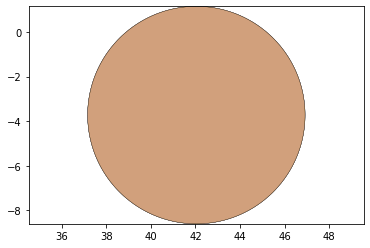

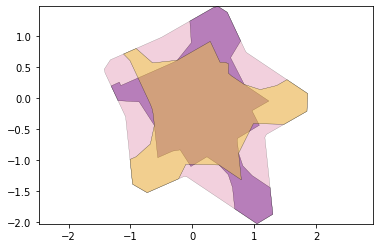

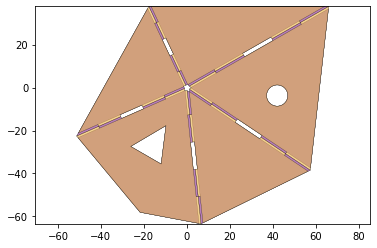

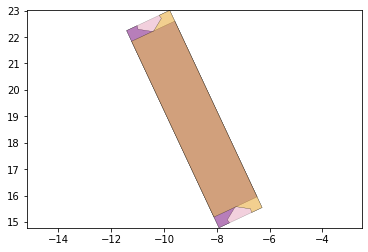

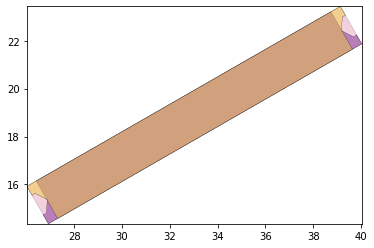

In [35]:
remaining_parts = foldable_robotics.manufacturing.find_connected(remaining_material,is_adhesive)
for item in remaining_parts:
    item.plot(new=True)

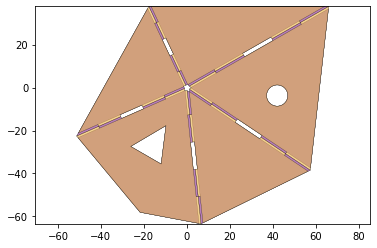

In [36]:
d3=design2>>1
for item in remaining_parts:
    if not (item&d3).is_null():
        break
item.plot()

In [37]:
check = (item^design2)
check>>=1e-5
check.plot()

('zero-size array to reduction operation minimum which has no identity',)


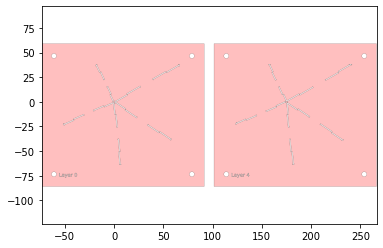

In [38]:
w,h = supported_design.get_dimensions()
p0,p1 = supported_design.bounding_box_coords()

rigid_layer = supported_design[0] | (supported_design[-1].translate(w+10,0))
rigid_layer.plot()

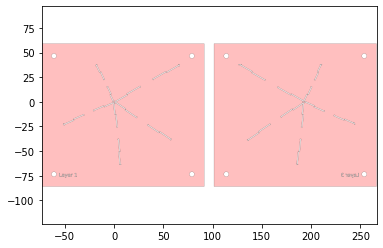

In [39]:
l4 = supported_design[3].scale(-1,1)
p2,p3 = l4.bounding_box_coords()
l4 = l4.translate(p0[0]-p2[0]+10+w,p0[1]-p2[1])

adhesive_layer = supported_design[1] | l4
adhesive_layer.plot()

In [40]:
first_pass = Laminate(rigid_layer,adhesive_layer,supported_design[2])

In [41]:
if check.is_null():
    first_pass.export_dxf('first_pass')
    final_cut.export_dxf('final_cut')